# Setup

In [1]:
import os

import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
# from torchvision.transforms import functional as F
from torch.nn import functional as F
import torchvision.transforms.functional as VF
from pycocotools.coco import COCO
import torchvision.transforms.v2 as T
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms

import matplotlib.pyplot as plt
from itertools import cycle

from tqdm.notebook import tqdm

import random
import numpy as np

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: fejowo5522 (fejowo5522-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# reduce cpu contention
torch.set_num_threads(1)
NUM_WORKERS = 6  # adjust based on CPU cores

cuda


In [4]:
COCO_PATH = "../../data/coco/"  # change this
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

REMOVE_IMAGES_WITHOUT_KEYPOINTS = True
VAL_SPLIT = 0.5
TEST_VAL_TRAIN_PERCENT = (0.1, 0.1, 0.1)
BATCH_SIZE = 128
DATA_AUGMENTATION = False

NUM_KEYPOINTS = 17

GRID_ROWS = 3
GRID_COLS = 3
MAX_PERSONS_PER_CELL = 2
MAX_PERSONS = GRID_ROWS * GRID_COLS * MAX_PERSONS_PER_CELL

# Data

In [5]:
class CustomTransform:
    def __init__(self, size=(256, 256), augmentation=False):
        if augmentation:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                T.ToDtype(torch.float32, scale=True),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
            ])

    
    def __call__(self, image, target):
        return self.transform(image), target


In [6]:
class CocoKeypointsDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None, filter_without_keypoints=True):
        super().__init__(img_folder, ann_file)
        self.coco = COCO(ann_file)
        self._transforms = transforms
        self.filter_without_keypoints = filter_without_keypoints

        if self.filter_without_keypoints:
            # Save the original ids before filtering
            original_ids = list(self.ids)  # Use self.ids after super().__init__
            self.ids = []
            for img_id in original_ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                anns_with_kp = [ann for ann in anns if 'keypoints' in ann and np.any(np.array(ann['keypoints']) != 0)]
                if len(anns_with_kp) > 0:
                    self.ids.append(img_id)

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        orig_w, orig_h = img.size  # PIL image size (width, height)
        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        # if self.filter_without_keypoints:
        #     # Filter for annotations with keypoints
        #     anns = [ann for ann in anns if 'keypoints' in ann and np.any(np.array(ann['keypoints']) != 0)]
        # else:
        #     anns = [ann for ann in anns if 'keypoints' in ann]

        target = {
            "image_id": self.ids[idx],
            "annotations": anns,
            "orig_size": (orig_w, orig_h)
        }
        if self._transforms:
            img, target = self._transforms(img, target)
            
        return img, target


In [7]:
def coco_collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack([img for img in imgs])
    batch_size = len(imgs)
    
    # Initialize target tensor [B, GRID_ROWS, GRID_COLS, MAX_PERSONS_PER_CELL, NUM_KEYPOINTS, 3]
    target_tensor = torch.zeros(
        (batch_size, GRID_ROWS, GRID_COLS, MAX_PERSONS_PER_CELL, NUM_KEYPOINTS, 3),
        dtype=torch.float32
    )
    
    for i, t in enumerate(targets):
        anns = t['annotations']
        orig_w, orig_h = t['orig_size']
        
        for ann in anns:
            kp = torch.tensor(ann['keypoints']).view(NUM_KEYPOINTS, 3).float()
            kp[:, 0] = kp[:, 0] * (256.0 / orig_w)  # Scale to 256x256
            kp[:, 1] = kp[:, 1] * (256.0 / orig_h)
            
            # Calculate person center from visible keypoints
            visible = kp[:, 2] > 0
            if visible.sum() == 0:
                continue
            center_x = kp[visible, 0].mean().item()
            center_y = kp[visible, 1].mean().item()
            
            # Determine grid cell
            cell_i = min(int(center_y * GRID_ROWS / 256), GRID_ROWS - 1)
            cell_j = min(int(center_x * GRID_COLS / 256), GRID_COLS - 1)
            
            # Find empty slot in grid cell
            for k in range(MAX_PERSONS_PER_CELL):
                if torch.all(target_tensor[i, cell_i, cell_j, k] == 0):
                    target_tensor[i, cell_i, cell_j, k] = kp
                    break
    
    # Flatten to [B, TOTAL_PERSONS, NUM_KEYPOINTS, 3]
    return imgs, target_tensor.reshape(batch_size, MAX_PERSONS, NUM_KEYPOINTS, 3)

In [8]:
train_dataset = CocoKeypointsDataset(
    IMG_DIR_TRAIN, 
    ANN_FILE_TRAIN, 
    transforms=CustomTransform(augmentation=DATA_AUGMENTATION), 
    filter_without_keypoints=REMOVE_IMAGES_WITHOUT_KEYPOINTS
)
val_dataset = CocoKeypointsDataset(
    IMG_DIR_VAL, 
    ANN_FILE_VAL, 
    transforms=CustomTransform(augmentation=False), 
    filter_without_keypoints=REMOVE_IMAGES_WITHOUT_KEYPOINTS
)

val_size = int(VAL_SPLIT * len(val_dataset))
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])


loading annotations into memory...
Done (t=5.66s)
creating index...
index created!
loading annotations into memory...
Done (t=6.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [9]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 56599
val dataset size: 1173
test dataset size: 1173


In [10]:
subset_len_train = int(TEST_VAL_TRAIN_PERCENT[0] * len(train_dataset))
subset_len_val = int(TEST_VAL_TRAIN_PERCENT[1] * len(val_dataset))
subset_len_test = int(TEST_VAL_TRAIN_PERCENT[2] * len(test_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, range(subset_len_train))
val_dataset = torch.utils.data.Subset(val_dataset, range(subset_len_val))
test_dataset = torch.utils.data.Subset(test_dataset, range(subset_len_test))

In [11]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=coco_collate_fn, 
    pin_memory=True,            # faster GPU transfer
    # persistent_workers=True     # maintain worker pool
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=coco_collate_fn, 
    pin_memory=True,
    # persistent_workers=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=coco_collate_fn, 
    pin_memory=True,
    # persistent_workers=True
)

In [12]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 5659
val dataset size: 117
test dataset size: 117


## Visualize data

In [13]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean


In [14]:
def visualize_prediction(img_tensor, keypoints_tensor, pred_keypoints_tensor=None):
    img = unnormalize(img_tensor).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    
    # Draw grid lines
    for i in range(1, GRID_ROWS):
        plt.axhline(y=i * 256 / GRID_ROWS, color='r', linestyle='-', alpha=0.3)
    for j in range(1, GRID_COLS):
        plt.axvline(x=j * 256 / GRID_COLS, color='r', linestyle='-', alpha=0.3)
    
    colors = cycle(plt.cm.tab10.colors)
    # Plot GT keypoints
    for i in range(0, MAX_PERSONS):
        kp = keypoints_tensor[i]
        if torch.all(kp == 0):
            continue
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')
    
    # Plot predicted keypoints
    if pred_keypoints_tensor is not None:
        colors_pred = cycle(plt.cm.Dark2.colors)
        for i in range(0, MAX_PERSONS):
            pk = pred_keypoints_tensor[i]
            pk = pk[pk[:, 2] >= 0.5]
            
            color = next(colors_pred)
            plt.scatter(pk[:, 0], pk[:, 1], color=color, marker='x', s=50, label=f'Pred {i+1}')
    
    plt.show()

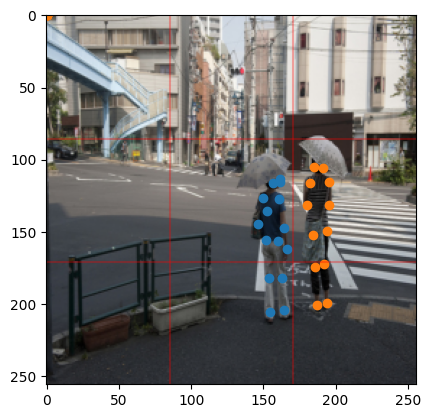

Person 1 keypoints:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
Person 2 keypoints:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
Person 3 keypoints:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0

In [15]:
# imgs, targets = next(iter(test_loader))
imgs, targets = next(iter(train_loader))

if 'test_iter' not in globals():
    test_iter = iter(test_loader)
    
try:
    imgs, targets = next(test_iter)
except StopIteration:
    test_iter = iter(test_loader)
    imgs, targets = next(test_iter)

imgs = imgs.to(device)


idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
keypoints = targets[idx]  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, keypoints)


for i, kp in enumerate(keypoints):
    print(f"Person {i+1} keypoints:\n{kp}")

# Model

## ResNet18

In [16]:
MODEL_NAME = "GridResNet18"

class KeypointModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.grid_rows = GRID_ROWS
        self.grid_cols = GRID_COLS
        self.max_persons_per_cell = MAX_PERSONS_PER_CELL
        self.total_persons = MAX_PERSONS
        
        resnet = resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((GRID_ROWS, GRID_COLS))
        self.conv_head = nn.Conv2d(512, MAX_PERSONS_PER_CELL * NUM_KEYPOINTS * 3, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = self.conv_head(x)  # [B, MAX_PERSONS_PER_CELL*NUM_KEYPOINTS*3, GRID_ROWS, GRID_COLS]
        x = x.permute(0, 2, 3, 1)  # [B, GRID_ROWS, GRID_COLS, MAX_PERSONS_PER_CELL*NUM_KEYPOINTS*3]
        x = x.view(x.size(0), self.grid_rows, self.grid_cols, self.max_persons_per_cell, NUM_KEYPOINTS, 3)
        x = x.reshape(x.size(0), self.total_persons, NUM_KEYPOINTS, 3)
        return x

# Model training functions

## Loss

In [17]:
# KEYPOINT_LOSS = "L1+BCE"

# def keypoint_loss(preds, targets):
#     # Coordinates: L1 loss
#     coord_mask = (targets[..., 2] > 0)  # only compute for visible keypoints
#     coord_loss = F.l1_loss(
#         preds[..., :2][coord_mask],
#         targets[..., :2][coord_mask],
#         reduction='sum'
#     ) / (coord_mask.sum() + 1e-8)

#     # Visibility: BCE loss
#     vis_loss = F.binary_cross_entropy_with_logits(
#         preds[..., 2],
#         (targets[..., 2] > 0).float(),  # Convert to binary
#         reduction='mean'
#     )

#     return coord_loss + vis_loss

In [18]:
KEYPOINT_LOSS = "MSE+BCE"

def keypoint_loss(preds, targets):
    # Coordinates: L1 loss
    coord_mask = (targets[..., 2] > 0)  # only compute for visible keypoints
    coord_loss = F.mse_loss(
        preds[..., :2][coord_mask],
        targets[..., :2][coord_mask],
        reduction='sum'
    ) / (coord_mask.sum() + 1e-8)

    # Visibility: BCE loss
    vis_loss = F.binary_cross_entropy_with_logits(
        preds[..., 2],
        (targets[..., 2] > 0).float(),  # Convert to binary
        reduction='mean'
    )

    return coord_loss + vis_loss

## Train loop

In [19]:
if device == 'cuda':
    scaler = torch.amp.GradScaler(device)

    def train_one_epoch(model, dataloader, optimizer, criterion, use_tqdm=False):
        model.train()
        total_loss = 0

        enumerator = tqdm(dataloader) if use_tqdm else dataloader
        for imgs, keypoints in enumerator:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device):
                preds = model(imgs)
                loss = criterion(preds, keypoints)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()

        return total_loss / len(dataloader)
else:
    def train_one_epoch(model, dataloader, optimizer, criterion, use_tqdm=False):
        model.train()
        total_loss = 0

        enumerator = tqdm(dataloader) if use_tqdm else dataloader
        for imgs, keypoints in enumerator:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)

            optimizer.zero_grad()

            preds = model(imgs)
            loss = criterion(preds, keypoints)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        return total_loss / len(dataloader)

In [20]:
def evaluate(model, dataloader):
    model.eval()
    preds_list, gt_list = [], []
    with torch.no_grad():
        for imgs, keypoints in dataloader:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)

            preds = model(imgs)
            preds_list.append(preds.cpu())
            gt_list.append(keypoints.cpu())
            
    # Concatenate all batches
    preds_all = torch.cat(preds_list, dim=0)
    gt_all = torch.cat(gt_list, dim=0)
    return preds_all, gt_all

# Train

In [21]:
EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

In [22]:
model = KeypointModel().to(device)

CRITERION_NAME = KEYPOINT_LOSS
criterion = keypoint_loss

OPTIMIZER_NAME = "Adam"
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
wandb_config = {
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    "train_size": subset_len_train,
    "val_size": subset_len_val,
    "test_size": subset_len_test,
    "model_name": MODEL_NAME,
    "criterion": CRITERION_NAME,
    "optimizer": OPTIMIZER_NAME,
    "num_keypoints": NUM_KEYPOINTS,
    "max_persons": MAX_PERSONS,
    "remove_images_without_keypoints": REMOVE_IMAGES_WITHOUT_KEYPOINTS,
    "val_split": VAL_SPLIT,
    "test_val_train_percent": TEST_VAL_TRAIN_PERCENT,
    "device": device,
    "data_augmentation": DATA_AUGMENTATION,
}

wandb.init(
    entity="fejowo5522-",
    project="NN_Project",
    config=wandb_config,
    group="KeypointDetection"
)

In [24]:
verbose_tqdm = False

early_stopping = True
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0


train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, use_tqdm=verbose_tqdm)
    train_losses.append(train_loss)

    preds_all, gt_all = evaluate(model, val_loader)
    val_loss = criterion(preds_all, gt_all).item()
    val_losses.append(val_loss)

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    if early_stopping:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "temp_best_model.pth")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 73


In [25]:
model.eval()

# Load best model if early stopping was used
if early_stopping and os.path.exists("temp_best_model.pth"):
    model.load_state_dict(torch.load("temp_best_model.pth"))

preds_all, gt_all = evaluate(model, test_loader)
test_loss = criterion(preds_all, gt_all).item()

wandb.log({
    'test_loss': test_loss
})

wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
test_loss,▁
train_loss,█▇▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,73
test_loss,2418.70361
train_loss,651.28759
val_loss,3612.5603


In [26]:
torch.save(model.state_dict(), "keypoint_model.pth")
print("Model saved to keypoint_model.pth")

Model saved to keypoint_model.pth


# Visualize

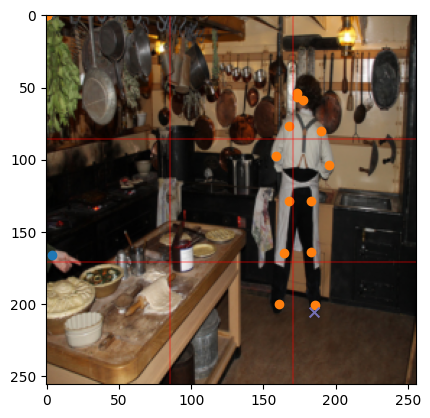

Person 1 keypoints:
tensor([[28.7353, 11.7551, -1.4105],
        [29.0702, 10.9775, -1.4164],
        [28.2652, 10.9808, -1.3894],
        [30.0557, 11.0476, -1.3602],
        [27.6298, 11.2341, -1.5188],
        [30.9754, 14.9267, -1.3168],
        [27.1792, 14.8693, -1.1779],
        [31.6240, 19.4792, -1.3867],
        [26.1265, 19.2085, -1.3002],
        [30.7406, 20.5312, -1.3591],
        [26.4452, 20.0253, -1.2259],
        [30.2758, 23.8172, -1.2923],
        [27.8997, 23.9607, -1.2841],
        [29.9200, 27.8599, -1.5041],
        [27.8091, 27.8292, -1.4666],
        [29.6642, 32.4677, -1.5737],
        [27.7330, 32.2458, -1.5751]])
Person 2 keypoints:
tensor([[28.7982, 12.7536, -2.0115],
        [29.0299, 12.0284, -2.3871],
        [28.4222, 11.9938, -2.3379],
        [29.5464, 12.4877, -2.3712],
        [28.0409, 12.5584, -2.6381],
        [29.7839, 15.1980, -2.2662],
        [27.9705, 15.2185, -2.2463],
        [30.2090, 18.8162, -2.3596],
        [27.5979, 18.7030, -2.4334

In [31]:
imgs, targets = next(iter(test_loader))

imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)

idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
gt_kpts_list = targets[idx]  # (MAX_PERSONS, 17, 3)
pred_kpts_list = preds[idx].cpu()  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, gt_kpts_list, pred_kpts_list)

for i, kp in enumerate(pred_kpts_list):
    print(f"Person {i+1} keypoints:\n{kp}")

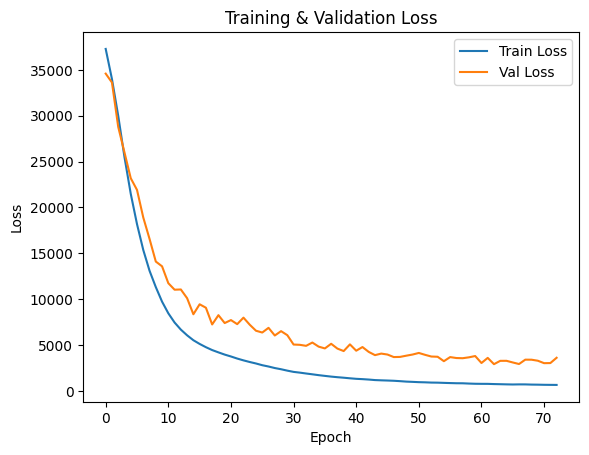

In [28]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()